# Roll no:015005

# Name: Ayushi Gupta

# Importing some important Libraries

In [24]:
from pyspark.sql import SparkSession

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

# Loading Dataset

In [25]:
spark = SparkSession.builder.appName('Insuranceregression').getOrCreate()
idata = spark.read.csv('insurance.csv', header=True, inferSchema=True)

In [26]:
idata.show(5)

+---+------+------+--------+------+---------+-----------+
|age|   sex|   bmi|children|smoker|   region|    charges|
+---+------+------+--------+------+---------+-----------+
| 19|female|  27.9|       0|   yes|southwest|  16884.924|
| 18|  male| 33.77|       1|    no|southeast|  1725.5523|
| 28|  male|  33.0|       3|    no|southeast|   4449.462|
| 33|  male|22.705|       0|    no|northwest|21984.47061|
| 32|  male| 28.88|       0|    no|northwest|  3866.8552|
+---+------+------+--------+------+---------+-----------+
only showing top 5 rows



In [27]:
idata.printSchema() #Checking for the schema of the dataframe that tell data type null value yes/no and column name

root
 |-- age: integer (nullable = true)
 |-- sex: string (nullable = true)
 |-- bmi: double (nullable = true)
 |-- children: integer (nullable = true)
 |-- smoker: string (nullable = true)
 |-- region: string (nullable = true)
 |-- charges: double (nullable = true)



In [28]:
idata.columns

['age', 'sex', 'bmi', 'children', 'smoker', 'region', 'charges']

In [29]:
len(idata.columns)

7

In [30]:
idata.describe().show()

+-------+------------------+------+------------------+-----------------+------+---------+------------------+
|summary|               age|   sex|               bmi|         children|smoker|   region|           charges|
+-------+------------------+------+------------------+-----------------+------+---------+------------------+
|  count|              1338|  1338|              1338|             1338|  1338|     1338|              1338|
|   mean| 39.20702541106129|  null|30.663396860986538|  1.0949177877429|  null|     null|13270.422265141257|
| stddev|14.049960379216147|  null| 6.098186911679012|1.205492739781914|  null|     null|12110.011236693992|
|    min|                18|female|             15.96|                0|    no|northeast|         1121.8739|
|    max|                64|  male|             53.13|                5|   yes|southwest|       63770.42801|
+-------+------------------+------+------------------+-----------------+------+---------+------------------+



# Data Visualization

+------+-----+
|smoker|count|
+------+-----+
|    no| 1064|
|   yes|  274|
+------+-----+



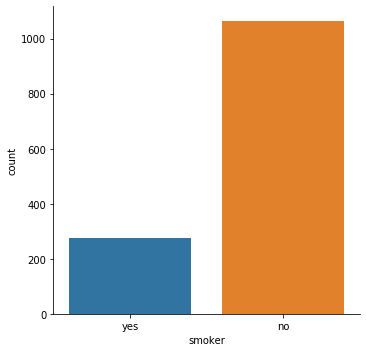

In [31]:
idata.groupby('smoker').count().show()
pddata = idata.toPandas()
sns.catplot(x='smoker', kind='count', data=pddata)

+--------+-----+
|children|count|
+--------+-----+
|       1|  324|
|       3|  157|
|       5|   18|
|       4|   25|
|       2|  240|
|       0|  574|
+--------+-----+



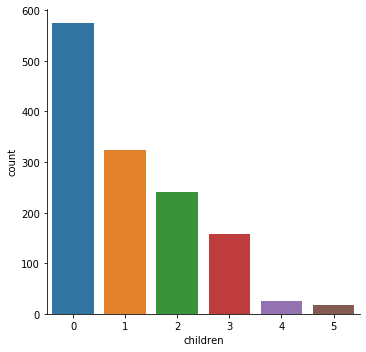

In [32]:
idata.groupby('children').count().show()
sns.catplot(x='children', kind='count', data=pddata)

Frequency of BMI less than 25: 247
Frequency of BMI greater than 25: 1091


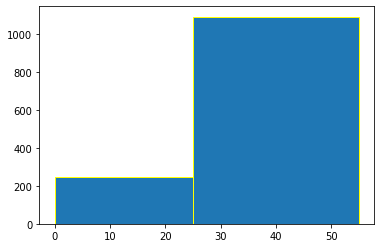

In [34]:
l=0
m=0
for i in pddata['bmi']:
    if (i<=25):
        l+=1
    else:
        m+=1
print('Frequency of BMI less than 25:', l)
print('Frequency of BMI greater than 25:', m)
plt.hist(pddata.bmi, bins=[0,25,55], edgecolor='yellow')
plt.show()

Text(0.5, 1.0, 'Plot of Age V/s Charges')

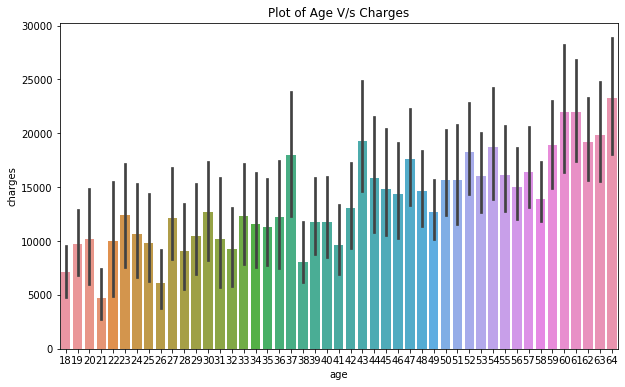

In [38]:
plt.figure(figsize=(10,6))
sns.barplot(x='age',y='charges', data=pddata)
plt.title('Plot of Age V/s Charges')

Average charges for <=2 children: 14576.0001291
Average charges for more than 2 children: 13040.970970948145


Text(0.5, 1.0, 'Plot for No. of Children V/S Charges')

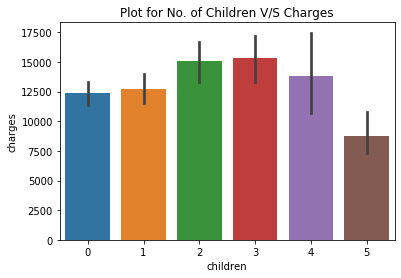

In [42]:
avg_chl,avg_chm = pddata['charges'][pddata['children'] > 2].mean(), pddata['charges'][pddata['children'] <= 2].mean()
print("Average charges for <=2 children:",avg_chl)
print("Average charges for more than 2 children:",avg_chm)
sns.barplot(x='children',y='charges', data=pddata)
plt.title('Plot for No. of Children V/S Charges')

Catagorical-numerical division

In [44]:
cat_cols = [x[0] for x in idata.dtypes if x[1]=='string']
cat_cols

['sex', 'smoker', 'region']

In [45]:
num_cols = [x[0] for x in idata.dtypes if x[1]!='string']
num_cols = num_cols[0:3]
num_cols

['age', 'bmi', 'children']

# Feature Engineering

In [46]:
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler, StandardScaler
Stages=[]

In [47]:
for cat_col in cat_cols:
    stringIndexer = StringIndexer(inputCol = cat_col, outputCol = cat_col + '_Index')
    encoder = OneHotEncoder(inputCols=[stringIndexer.getOutputCol()],outputCols = [cat_col +'_OHE'])
    Stages += [stringIndexer, encoder]
assemblerInputs = [c + '_OHE' for c in cat_cols] + num_cols
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol='asv_features')
Stages += [assembler]
standardscaler = StandardScaler(inputCol='asv_features', outputCol='features')
Stages += [standardscaler]

Pipeline Creation

In [48]:
from pyspark.ml import Pipeline
pipeline = Pipeline(stages = stages)
pipelineModel = pipeline.fit(idata)
df_pipetrans = pipelineModel.transform(idata)
df_trans = df_pipetrans.select('features','charges')

In [49]:
df_trans = df_trans.withColumnRenamed('charges','label')

# Splitting into train & test data

In [50]:
train_df, test_df = df_trans.randomSplit([0.7,0.3], seed = 1000)

In [51]:
from pyspark.ml.regression import LinearRegression
lm = LinearRegression(featuresCol='features',labelCol='label')
lm_model = lm.fit(train_df)

Training Model

In [52]:
trainSummary=lm_model.summary
print("MAE: ", trainSummary.meanAbsoluteError)
print("MSE: ", trainSummary.meanSquaredError)
print("RMSE: ", trainSummary.rootMeanSquaredError)
print("R2: ", trainSummary.r2)

MAE:  4329.461884783387
MSE:  38513671.79359384
RMSE:  6205.938429729531
R2:  0.7528094593274948


# Model Preparation

In [53]:
lm_predictions = lm_model.transform(test_data)
lm_predictions.select('features','prediction','label').show(5)

+--------------------+------------------+----------+
|            features|        prediction|     label|
+--------------------+------------------+----------+
|(8,[0,1,5,6],[1.9...|-2407.965149039628| 1694.7964|
|(8,[0,1,5,6],[1.9...|-452.6092736278242| 1702.4553|
|(8,[0,1,5,6],[1.9...| 356.5035024046465| 1705.6245|
|(8,[0,1,5,6],[1.9...| 7142.661623200489|3268.84665|
|(8,[0,1,5,6],[1.9...| 8394.963130345834|12404.8791|
+--------------------+------------------+----------+
only showing top 5 rows



In [54]:
from pyspark.ml.evaluation import RegressionEvaluator
lm_evaluator = RegressionEvaluator(predictionCol = 'prediction',labelCol='label',metricName='r2')
print("R Squared on test data: ", lm_evaluator.evaluate(lm_predictions))

R Squared on test data:  0.7515714217562277


In [55]:
# Displaying metrics of the model over test data
res = lm_model.evaluate(test_data)
print("MAE: ", res.meanAbsoluteError)
print("MSE: ", res.meanSquaredError)
print("RMSE: ", res.rootMeanSquaredError)
print("R2: ", res.r2)

MAE:  4256.629124972366
MSE:  39051729.00036686
RMSE:  6249.1382606217685
R2:  0.7515714217562277
